In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aids-virus-infection-prediction/AIDS_Classification_15000.csv
/kaggle/input/aids-virus-infection-prediction/AIDS_Classification_50000.csv
/kaggle/input/aids-virus-infection-prediction/AIDS_Classification.csv
/kaggle/input/aids-virus-infection-prediction/AIDS_Classification_5000.csv


## --- Funções ---

In [7]:
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


def kfolds(X, y, folds): #Divide os dados em folds para validação cruzada estratificada.
    
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    # Garante que X e y são arrays numpy para indexação
    X_np = np.array(X)
    y_np = np.array(y)

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_np, y_np):
        X_train_list.append(X_np[train_index])
        X_test_list.append(X_np[test_index])
        y_train_list.append(y_np[train_index])
        y_test_list.append(y_np[test_index])

    return X_train_list, X_test_list, y_train_list, y_test_list

def normalize_numerical(X, numerical_cols): #Normaliza apenas as colunas numéricas especificadas usando MinMaxScaler.

    X_normalized = X.copy()
    scaler = MinMaxScaler()
    X_normalized[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    return X_normalized

def rfe(X_processed, y, max_iter, features_to_select): 
    # Realiza a seleção de features usando Recursive Feature Elimination(RFE)
    # com Regressão Logística.

    modeloRFE = LogisticRegression(max_iter=max_iter, solver='liblinear', random_state=42)
    rfe_selector = RFE(modeloRFE, n_features_to_select=features_to_select)
    fitRFE = rfe_selector.fit(X_processed, y)
    selected_features = X_processed.columns[fitRFE.support_]
    return X_processed[selected_features]

def specificity_score(y_true, y_pred): # Calcula a especificidade (True Negative Rate).
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tn + fp) == 0:
        return 0.0
    return tn / (tn + fp)

## --- Carregamento e Pré-processamento dos Dados ---

In [5]:
dataset = pd.read_csv("/kaggle/input/aids-virus-infection-prediction/AIDS_Classification_15000.csv")

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      15000 non-null  int64  
 1   trt       15000 non-null  int64  
 2   age       15000 non-null  int64  
 3   wtkg      15000 non-null  float64
 4   hemo      15000 non-null  int64  
 5   homo      15000 non-null  int64  
 6   drugs     15000 non-null  int64  
 7   karnof    15000 non-null  int64  
 8   oprior    15000 non-null  int64  
 9   z30       15000 non-null  int64  
 10  preanti   15000 non-null  int64  
 11  race      15000 non-null  int64  
 12  gender    15000 non-null  int64  
 13  str2      15000 non-null  int64  
 14  strat     15000 non-null  int64  
 15  symptom   15000 non-null  int64  
 16  treat     15000 non-null  int64  
 17  offtrt    15000 non-null  int64  
 18  cd40      15000 non-null  int64  
 19  cd420     15000 non-null  int64  
 20  cd80      15000 non-null  in

In [23]:
dataset.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.0000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,876.719667,1.395333,34.273800,76.019604,0.032000,0.652733,0.127867,96.777533,0.041067,0.645867,...,0.577000,1.937267,0.087933,0.7364,0.348800,318.754800,436.178600,1049.644400,908.306867,0.308733
std,308.105122,1.237880,7.074134,12.170759,0.176006,0.476117,0.333952,5.135257,0.198451,0.478266,...,0.494052,0.894456,0.283207,0.4406,0.476606,102.653183,142.800481,489.881489,337.759073,0.461986
min,68.000000,0.000000,12.000000,42.256390,0.000000,0.000000,0.000000,77.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,111.000000,273.000000,143.000000,0.000000
25%,539.000000,0.000000,29.000000,68.323125,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.0000,0.000000,235.000000,327.000000,716.000000,652.000000,0.000000
50%,1045.000000,1.000000,34.000000,74.114225,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,2.000000,0.000000,1.0000,0.000000,298.000000,413.000000,887.000000,858.000000,0.000000
75%,1137.000000,3.000000,39.000000,81.309035,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,1.0000,1.000000,396.000000,527.000000,1252.250000,1087.250000,1.000000
max,1231.000000,3.000000,68.000000,141.612390,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.0000,1.000000,996.000000,1119.000000,4867.000000,3253.000000,1.000000


## --- Gráficos ---

### Distribuição das Variáveis Numéricas (Histogramas e Box Plots):

Objetivo: Entender a distribuição de cada feature numérica. Histogramas mostram a forma da distribuição (normal, assimétrica, etc.), enquanto Box Plots são excelentes para identificar outliers e a dispersão dos dados.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

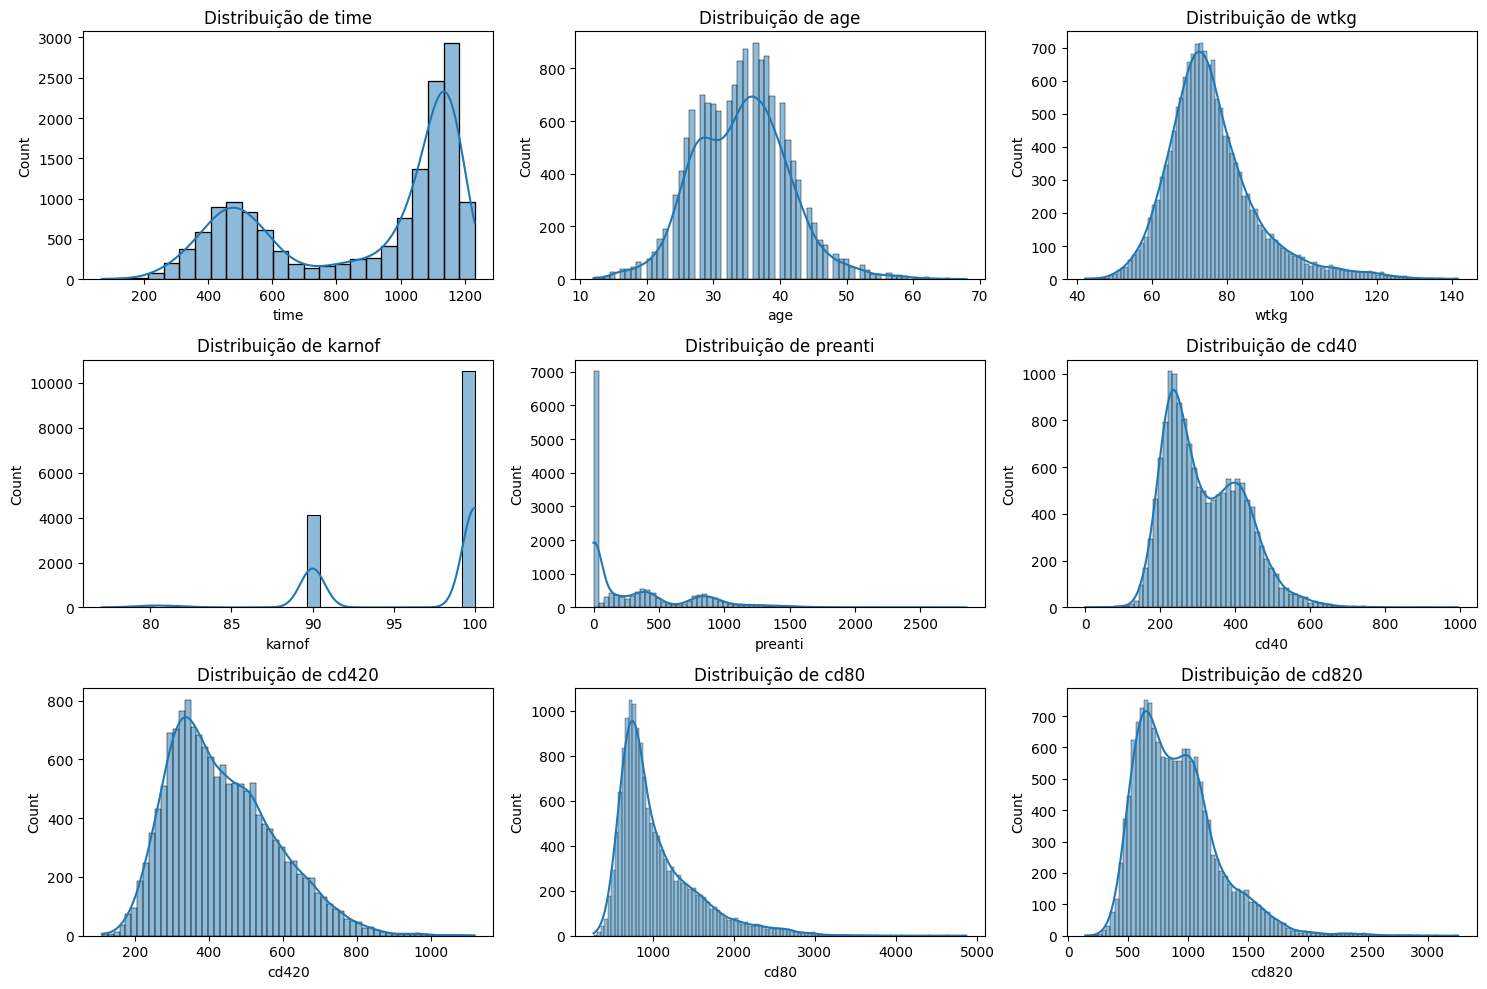

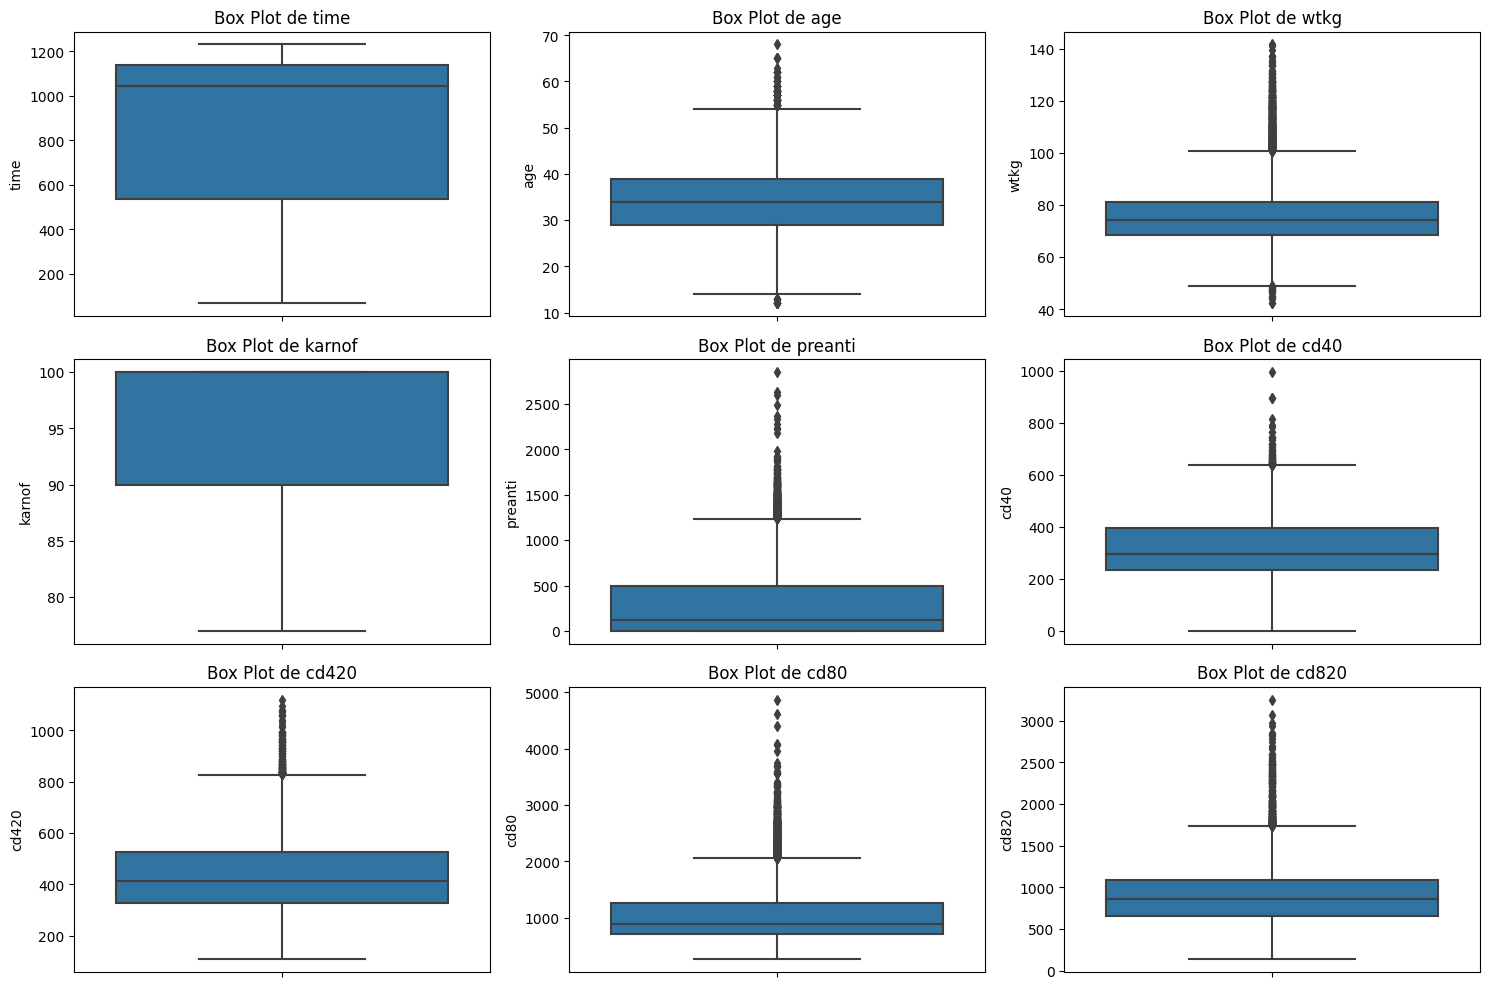

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(dataset[col], kde=True)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=dataset[col])
    plt.title(f'Box Plot de {col}')
plt.tight_layout()
plt.show()


### Relação entre Features Numéricas e Target (Box Plots ou Violin Plots):

Objetivo: Visualizar se a distribuição de uma feature numérica difere significativamente entre as classes infected e not infected.

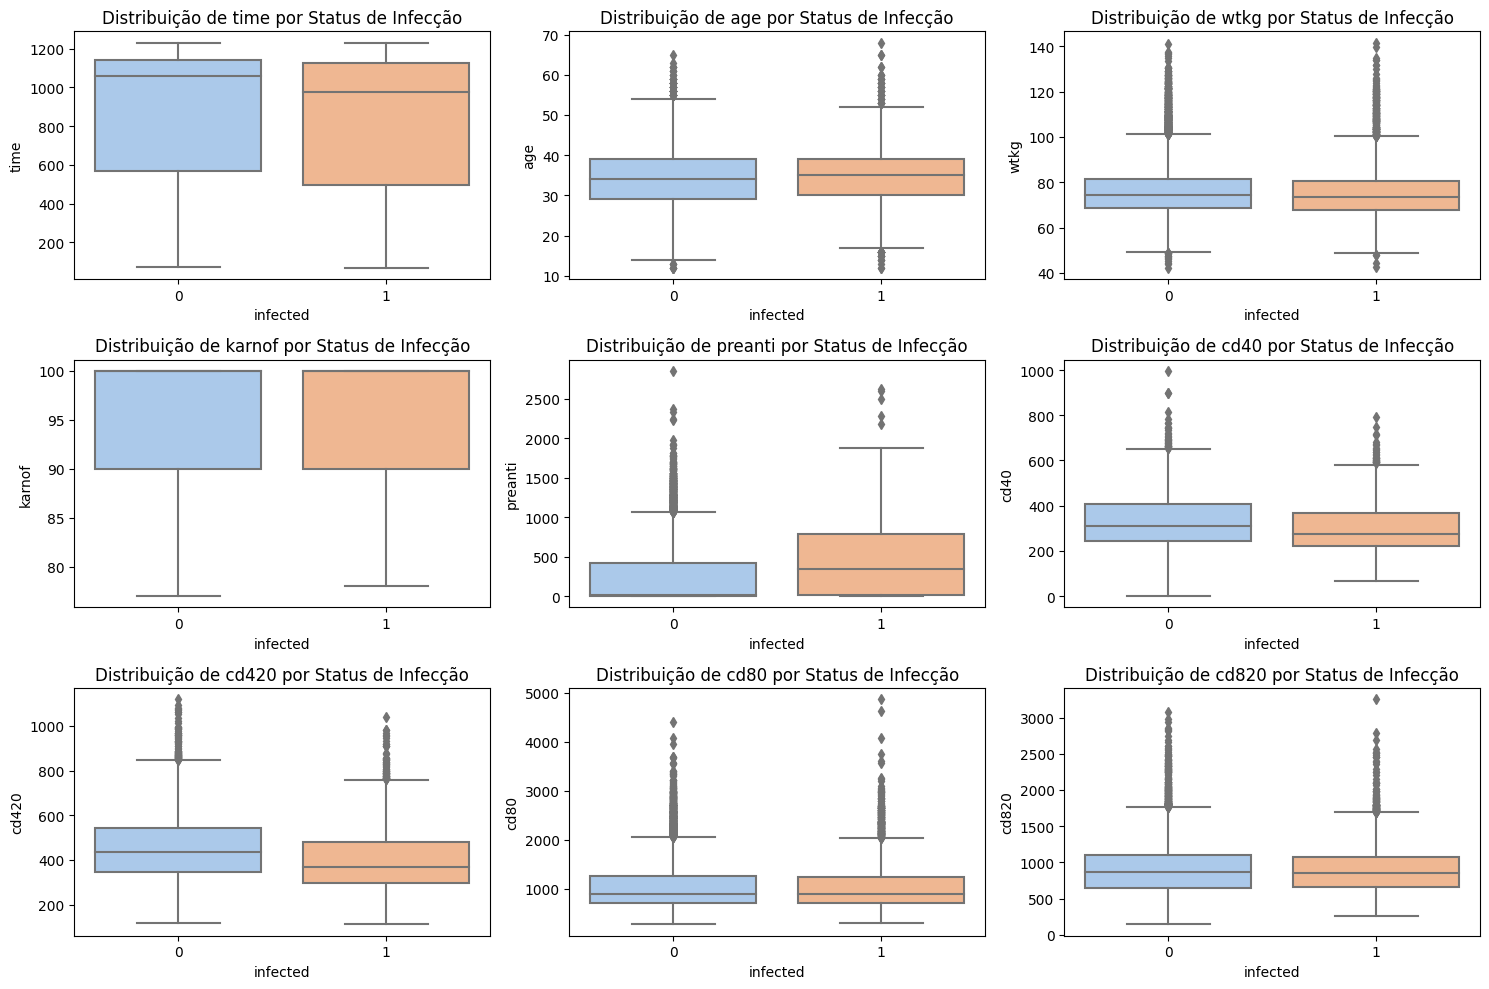

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='infected', y=col, data=dataset, palette='pastel')
    plt.title(f'Distribuição de {col} por Status de Infecção')
plt.tight_layout()
plt.show()

### Matriz de Correlação (Heatmap):

Objetivo: Visualizar a correlação entre todas as features numéricas. Isso pode ajudar a identificar features redundantes ou importantes.

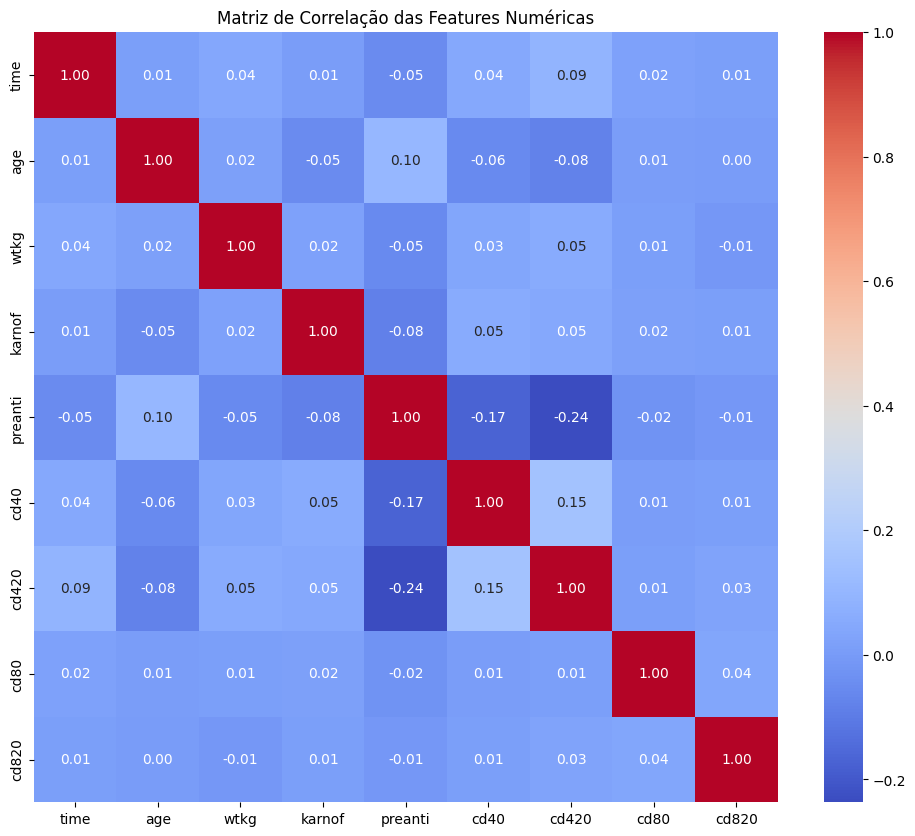

In [9]:
plt.figure(figsize=(12, 10))
corr_matrix = dataset[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Features Numéricas')
plt.show()

### Contagem de Classes da Variável Alvo (infected):

Objetivo: Verificar o balanceamento da classe alvo. Como você já identificou um desbalanceamento, esta visualização confirmará a proporção.

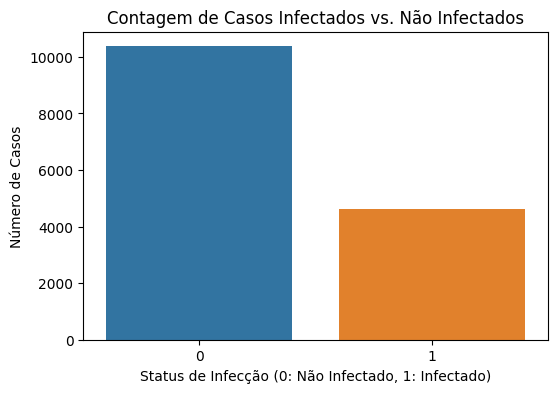

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='infected', data=dataset)
plt.title('Contagem de Casos Infectados vs. Não Infectados')
plt.xlabel('Status de Infecção (0: Não Infectado, 1: Infectado)')
plt.ylabel('Número de Casos')
plt.show()


### Relação entre Features Categóricas/Binárias e Target (Gráficos de Barras Agrupados):

Objetivo: Entender como cada categoria de uma feature categórica se relaciona com a probabilidade de infecção.

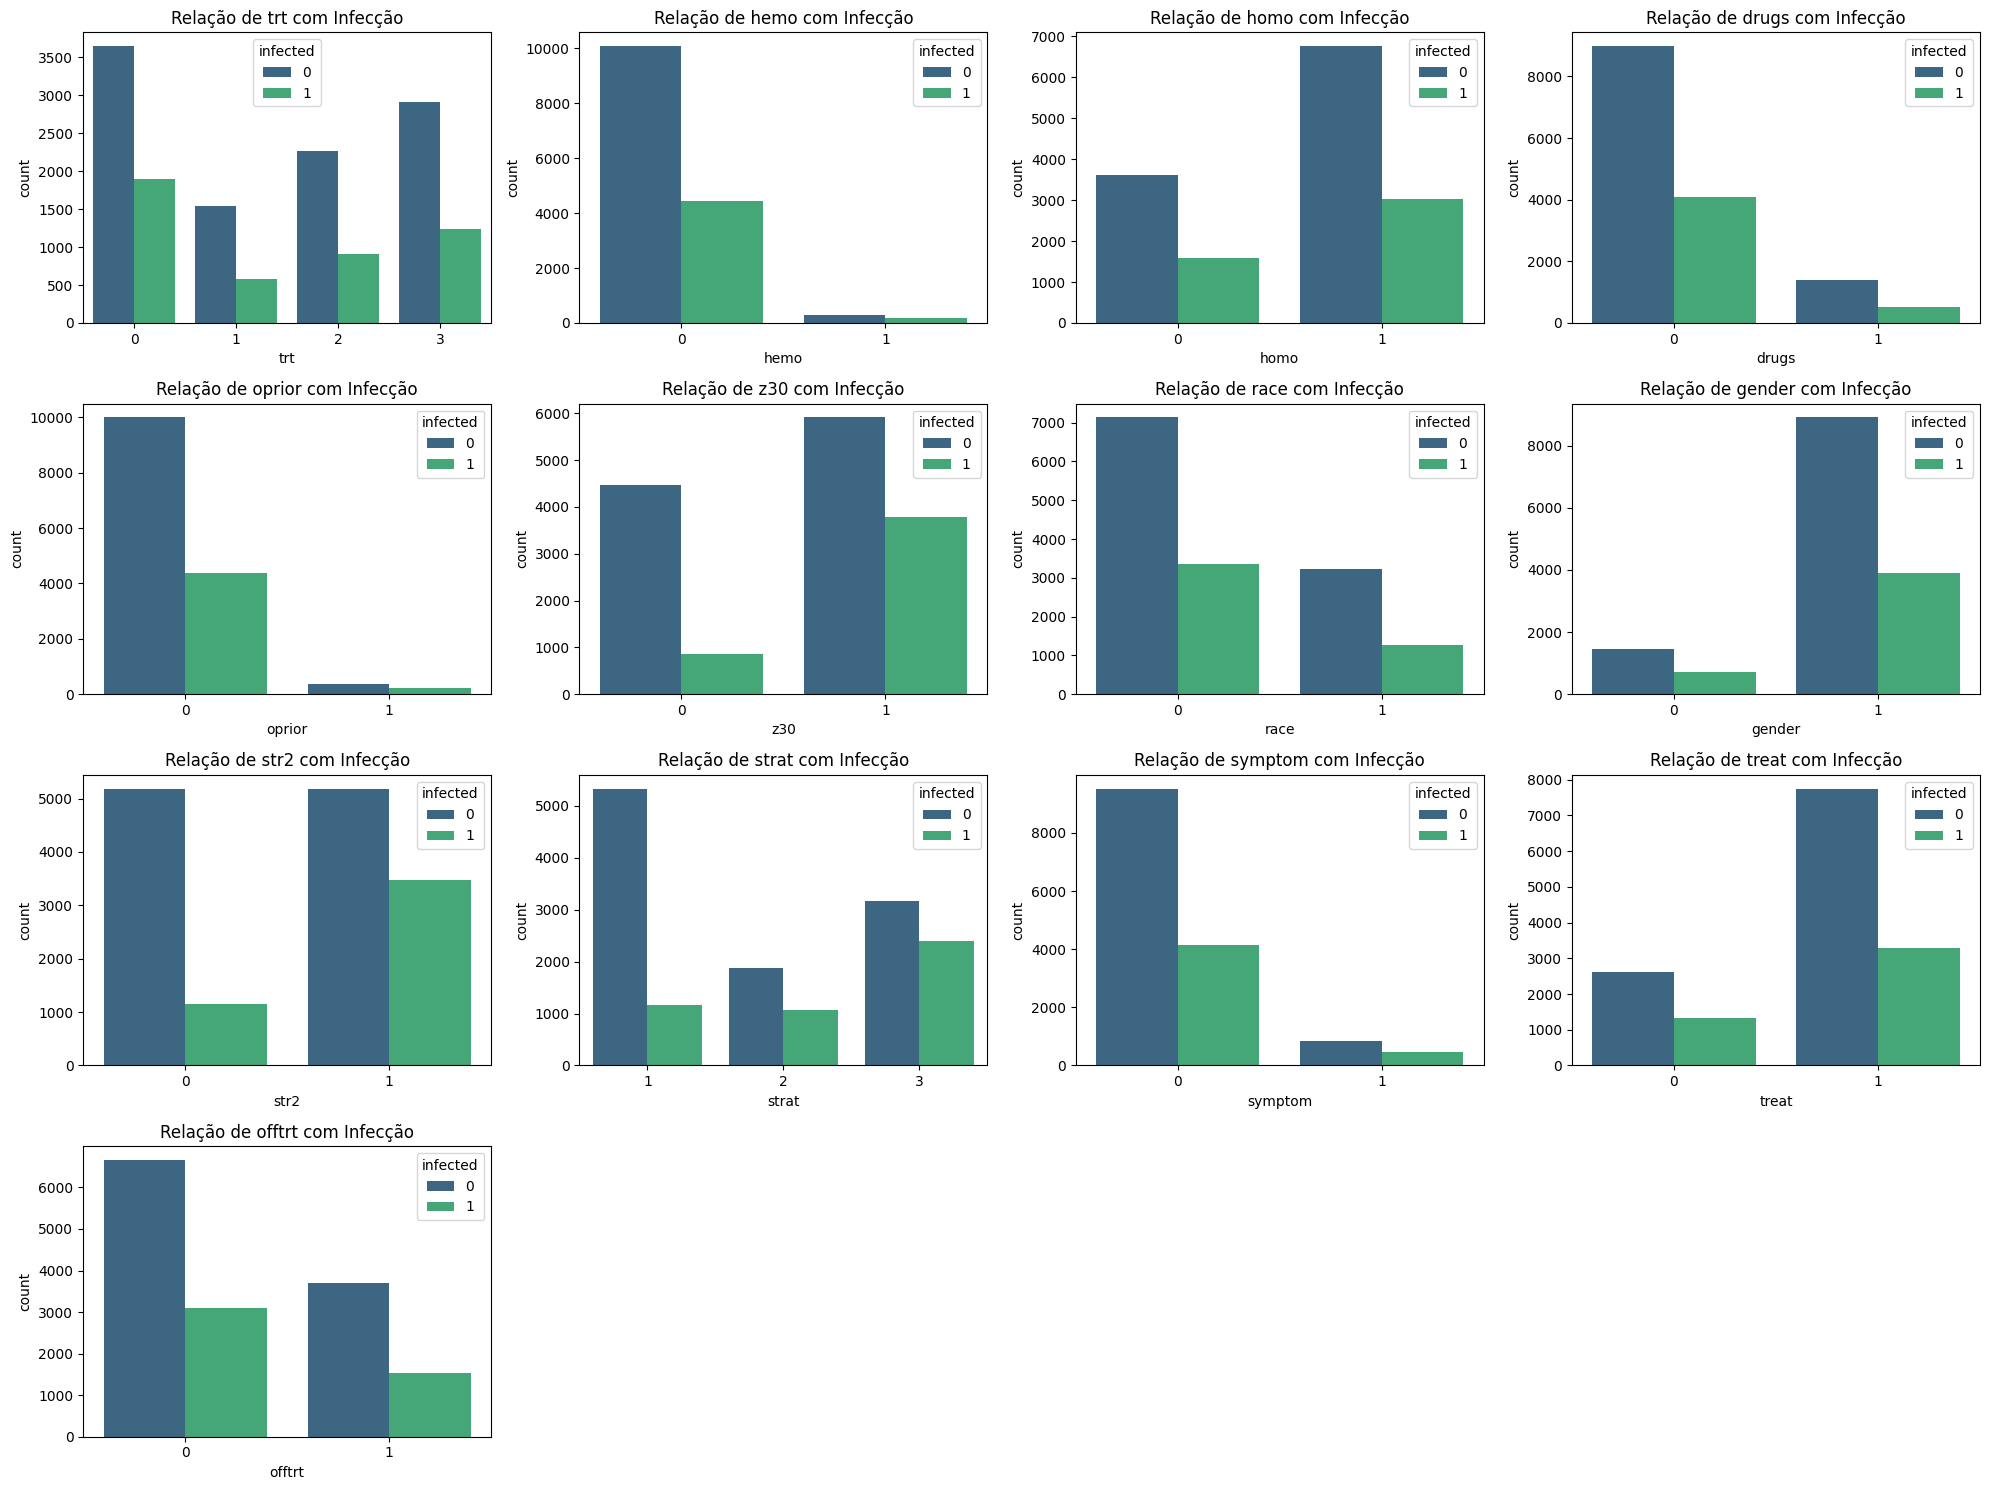

In [12]:
categorical_cols = ['trt', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt']
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 4, i + 1)
    sns.countplot(x=col, hue='infected', data=dataset, palette='viridis')
    plt.title(f'Relação de {col} com Infecção')
plt.tight_layout()
plt.show()

## --- Configuração dos Modelos ---

In [10]:
# Importações dos modelos e métricas
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (BaggingClassifier,
                              RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             roc_auc_score)

In [8]:
# Pré-processamento (one-hot encode categóricas, normaliza numéricas),
# seleção de features e divisão em folds para validação cruzada.

y = dataset['infected']
X_raw = dataset.drop(columns=['infected'])

# Identificação das colunas
numerical_cols = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
categorical_nominal_cols = ['trt', 'race', 'strat']
# As colunas binárias como hemo, homo, drugs, etc., podem ser mantidas como estão

# Aplicar One-Hot Encoding para colunas nominais. drop_first para evitar multicolinearidade
X_encoded = pd.get_dummies(X_raw, columns=categorical_nominal_cols, drop_first=True)

# Normalizar apenas as colunas numéricas contínuas
X_normalized = normalize_numerical(X_encoded, numerical_cols)

# Assumindo que você quer 8 features selecionadas e max_iter=1000 para RFE
# RFE será aplicado sobre o DataFrame já com one-hot encoding e normalização seletiva
X_final = rfe(X_normalized, y, 1000, 8)

folds = 5 # Número de folds fixo, pode ser parametrizado se necessário

X_train, X_test, y_train, y_test = kfolds(X_final, y, folds)

In [11]:
# Dicionário para armazenar as instâncias de cada modelo com seus nomes
models_to_evaluate = {
    "DecisionTree_Default": DecisionTreeClassifier(random_state=42),
    "SVC_Default": SVC(probability=True, random_state=42),
    "KNeighbors_Default": KNeighborsClassifier(),
    "BaggingClassifier": BaggingClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "XGBoostClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBMClassifier": lgb.LGBMClassifier(random_state=42),
    "DecisionTree_Entropy": DecisionTreeClassifier(criterion='entropy', random_state=0),
    "SVC_Linear": SVC(kernel='linear', probability=True, random_state=42),
    "KNeighbors_N6_Auto": KNeighborsClassifier(n_neighbors=6, algorithm='auto'),
    "DecisionTree_MaxDepth10": DecisionTreeClassifier(max_depth=10, random_state=0),
    "SVC_Poly_Degree5": SVC(kernel='poly', degree=5, probability=True, random_state=42),
    "KNeighbors_N7_BallTree": KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')
}

# Dicionário para armazenar as métricas de todos os modelos em cada fold
all_model_metrics = {}
for model_name in models_to_evaluate.keys():
    all_model_metrics[model_name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'specificity': [],
        'roc_auc_value': [],
        'y_true_folds': [],  # Armazena os rótulos verdadeiros de cada fold
        'y_proba_folds': []  # Armazena as probabilidades previstas de cada fold
    }

## --- Loop de Validação Cruzada ---

In [12]:
print(f"Iniciando validação cruzada com {folds} folds...")
for fold_idx in range(folds):
    xtrain = X_train[fold_idx]
    xtest = X_test[fold_idx]
    ytrain = y_train[fold_idx]
    ytest = y_test[fold_idx]

    print(f"\n--- Fold {fold_idx + 1}/{folds} ---")

    for model_name, model_instance in models_to_evaluate.items():
        try:
            # Para XGBoost, 'scale_pos_weight' precisa ser ajustado por fold
            if model_name == "XGBoostClassifier":
                neg_count = np.sum(ytrain == 0)
                pos_count = np.sum(ytrain == 1)
                model_instance.set_params(scale_pos_weight=neg_count / pos_count)

            # Treinamento do modelo
            model = model_instance.fit(xtrain, ytrain)
            result = model.predict(xtest)

            # Cálculo das métricas
            acc = accuracy_score(ytest, result)
            prec = precision_score(ytest, result, zero_division=0)
            rec = recall_score(ytest, result, zero_division=0)
            spec = specificity_score(ytest, result)

            # Para AUC, precisamos das probabilidades
            current_fold_auc = np.nan # Inicializa com NaN
            y_proba = np.array([]) # Inicializa como array vazio
            if hasattr(model, "predict_proba"):
                try:
                    y_proba = model.predict_proba(xtest)[:, 1]
                    current_fold_auc = roc_auc_score(ytest, y_proba)
                    # Armazena y_true e y_proba para a plotagem da curva ROC combinada
                    all_model_metrics[model_name]['y_true_folds'].append(ytest)
                    all_model_metrics[model_name]['y_proba_folds'].append(y_proba)
                except ValueError as e:
                    print(f"  Aviso: Não foi possível calcular AUC para {model_name} no fold {fold_idx + 1} (probabilidades): {e}")
                    all_model_metrics[model_name]['y_true_folds'].append(np.array([])) # Adiciona array vazio em caso de erro
                    all_model_metrics[model_name]['y_proba_folds'].append(np.array([])) # Adiciona array vazio em caso de erro
            else:
                print(f"  Aviso: Modelo {model_name} não suporta predict_proba para AUC.")
                all_model_metrics[model_name]['y_true_folds'].append(np.array([])) # Adiciona array vazio se não suportar proba
                all_model_metrics[model_name]['y_proba_folds'].append(np.array([])) # Adiciona array vazio se não suportar proba

            # Armazenamento das métricas
            all_model_metrics[model_name]['accuracy'].append(acc)
            all_model_metrics[model_name]['precision'].append(prec)
            all_model_metrics[model_name]['recall'].append(rec)
            all_model_metrics[model_name]['specificity'].append(spec)
            all_model_metrics[model_name]['roc_auc_value'].append(current_fold_auc)

            # Opcional: Imprimir métricas para cada fold
            # print(f"  Modelo: {model_name} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, Spec: {spec:.4f}, AUC: {auc_score:.4f}")

        except Exception as e:
            print(f"  Erro ao treinar/avaliar {model_name} no fold {fold_idx + 1}: {e}")
            # Adiciona NaN para todas as métricas e arrays vazios para y_true/y_proba em caso de erro
            for metric_key in ['accuracy', 'precision', 'recall', 'specificity', 'auc']:
                all_model_metrics[model_name][metric_key].append(np.nan)
            all_model_metrics[model_name]['y_true_folds'].append(np.array([]))
            all_model_metrics[model_name]['y_proba_folds'].append(np.array([]))

Iniciando validação cruzada com 5 folds...

--- Fold 1/5 ---
[LightGBM] [Info] Number of positive: 3704, number of negative: 8296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.308667 -> initscore=-0.806360
[LightGBM] [Info] Start training from score -0.806360

--- Fold 2/5 ---
[LightGBM] [Info] Number of positive: 3705, number of negative: 8295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 8
[LightGBM

## --- Exibição dos Resultados Médios e Desvio Padrão ---

In [14]:
print("\n--- Resultados Médios da Validação Cruzada ---")
final_results = {}
for model_name, metrics in all_model_metrics.items():
    # Filtra NaNs antes de calcular a média e o desvio padrão
    accuracies_clean = [m for m in metrics['accuracy'] if not np.isnan(m)]
    precisions_clean = [m for m in metrics['precision'] if not np.isnan(m)]
    recalls_clean = [m for m in metrics['recall'] if not np.isnan(m)]
    specificities_clean = [m for m in metrics['specificity'] if not np.isnan(m)]
    aucs_clean = [m for m in metrics['roc_auc_value'] if not np.isnan(m)]

    avg_accuracy = np.mean(accuracies_clean) if accuracies_clean else np.nan
    std_accuracy = np.std(accuracies_clean) if accuracies_clean else np.nan
    avg_precision = np.mean(precisions_clean) if precisions_clean else np.nan
    avg_recall = np.mean(recalls_clean) if recalls_clean else np.nan
    avg_specificity = np.mean(specificities_clean) if specificities_clean else np.nan
    avg_auc = np.mean(aucs_clean) if aucs_clean else np.nan

    final_results[model_name] = {
        'avg_accuracy': avg_accuracy,
        'std_accuracy': std_accuracy,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_specificity': avg_specificity,
        'avg_auc': avg_auc
    }
    print(f"\nModelo: {model_name}")
    print(f"  Acurácia Média: {avg_accuracy:.4f} (Desvio Padrão: {std_accuracy:.4f})")
    print(f"  Precisão Média: {avg_precision:.4f}")
    print(f"  Recall Médio: {avg_recall:.4f}")
    print(f"  Especificidade Média: {avg_specificity:.4f}")
    print(f"  AUC Média: {avg_auc:.4f}")



--- Resultados Médios da Validação Cruzada ---

Modelo: DecisionTree_Default
  Acurácia Média: 0.6138 (Desvio Padrão: 0.0062)
  Precisão Média: 0.3804
  Recall Médio: 0.3986
  Especificidade Média: 0.7099
  AUC Média: 0.5543

Modelo: SVC_Default
  Acurácia Média: 0.7005 (Desvio Padrão: 0.0027)
  Precisão Média: 0.5744
  Recall Médio: 0.1179
  Especificidade Média: 0.9607
  AUC Média: 0.6342

Modelo: KNeighbors_Default
  Acurácia Média: 0.6669 (Desvio Padrão: 0.0092)
  Precisão Média: 0.4444
  Recall Médio: 0.3101
  Especificidade Média: 0.8263
  AUC Média: 0.6229

Modelo: BaggingClassifier
  Acurácia Média: 0.6789 (Desvio Padrão: 0.0083)
  Precisão Média: 0.4637
  Recall Médio: 0.2490
  Especificidade Média: 0.8710
  AUC Média: 0.6365

Modelo: RandomForestClassifier
  Acurácia Média: 0.6924 (Desvio Padrão: 0.0067)
  Precisão Média: 0.5043
  Recall Médio: 0.2529
  Especificidade Média: 0.8887
  AUC Média: 0.6641

Modelo: GradientBoostingClassifier
  Acurácia Média: 0.7059 (Desvio Padrã

## --- Avaliação e Comparação de Modelos ---
Após o treinamento, as visualizações são cruciais para comparar o desempenho dos seus diversos modelos.

Comparação de Métricas (Gráficos de Barras):

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

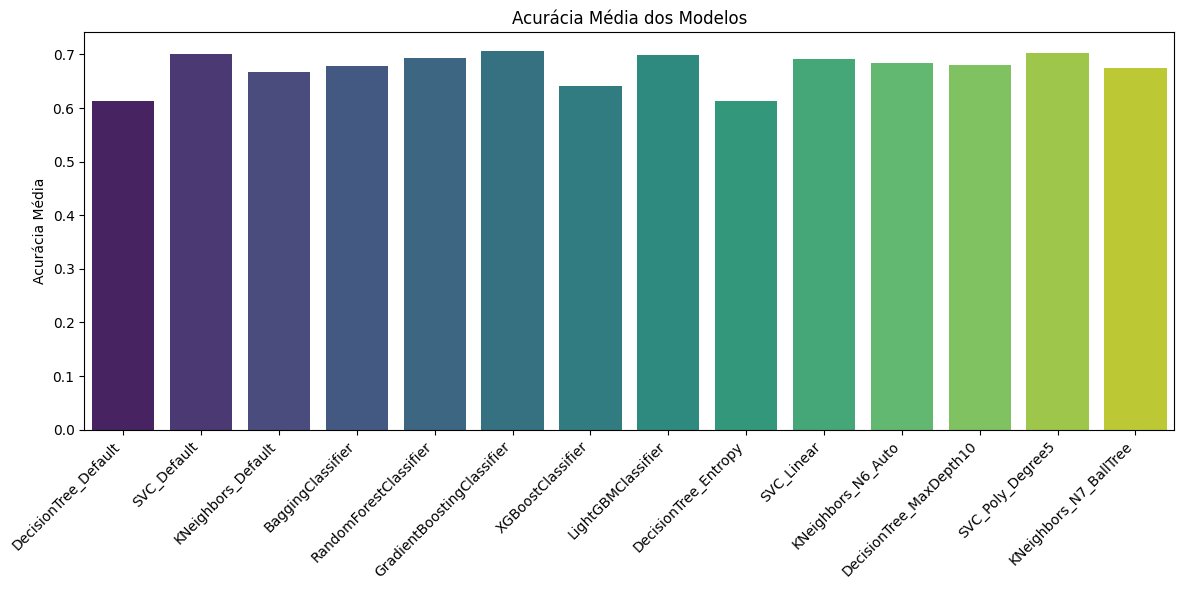

In [20]:
# Acurácia
results_df = pd.DataFrame.from_dict(final_results, orient='index')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='avg_accuracy', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Acurácia Média')
plt.title('Acurácia Média dos Modelos')
plt.tight_layout()
plt.show()

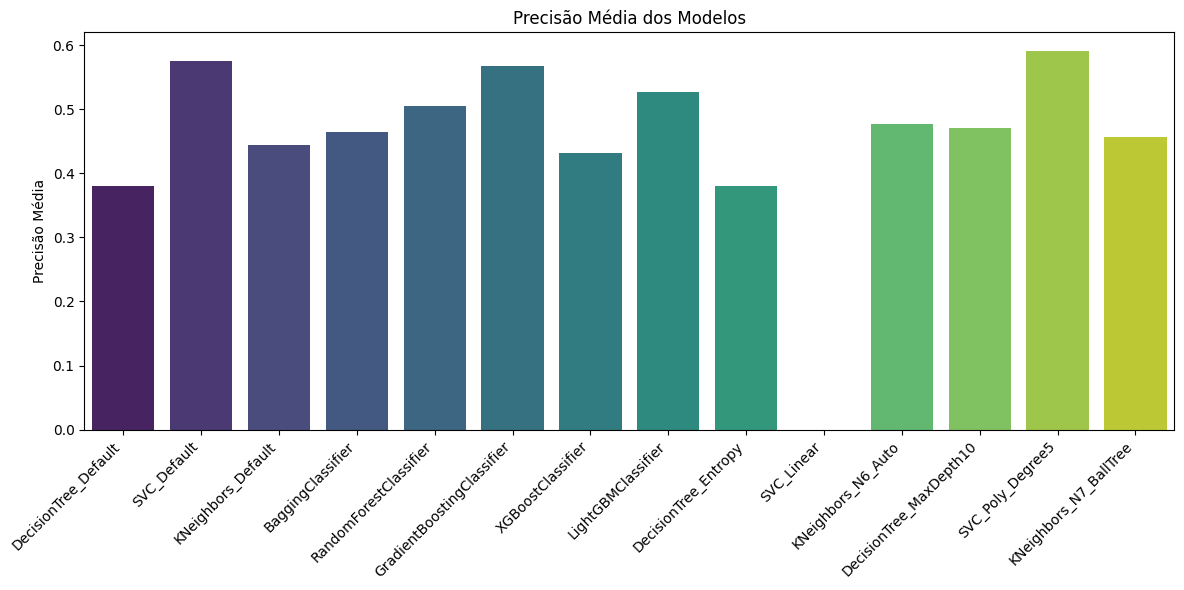

In [21]:
# Precision
results_df = pd.DataFrame.from_dict(final_results, orient='index')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='avg_precision', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Precisão Média')
plt.title('Precisão Média dos Modelos')
plt.tight_layout()
plt.show()

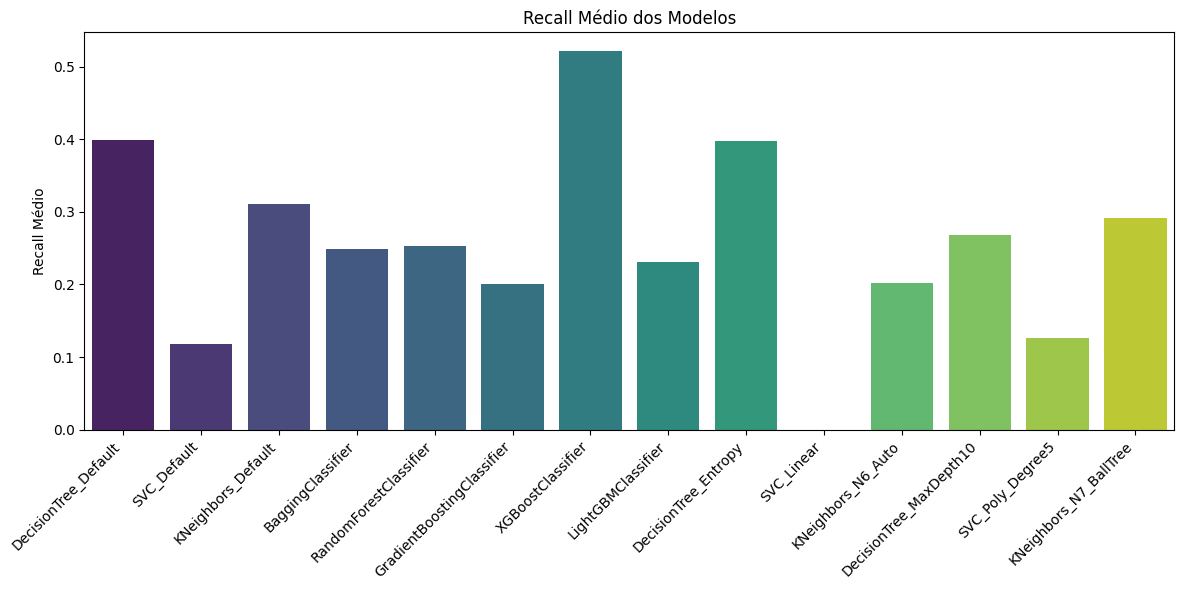

In [22]:
# Recall
results_df = pd.DataFrame.from_dict(final_results, orient='index')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='avg_recall', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Recall Médio')
plt.title('Recall Médio dos Modelos')
plt.tight_layout()
plt.show()

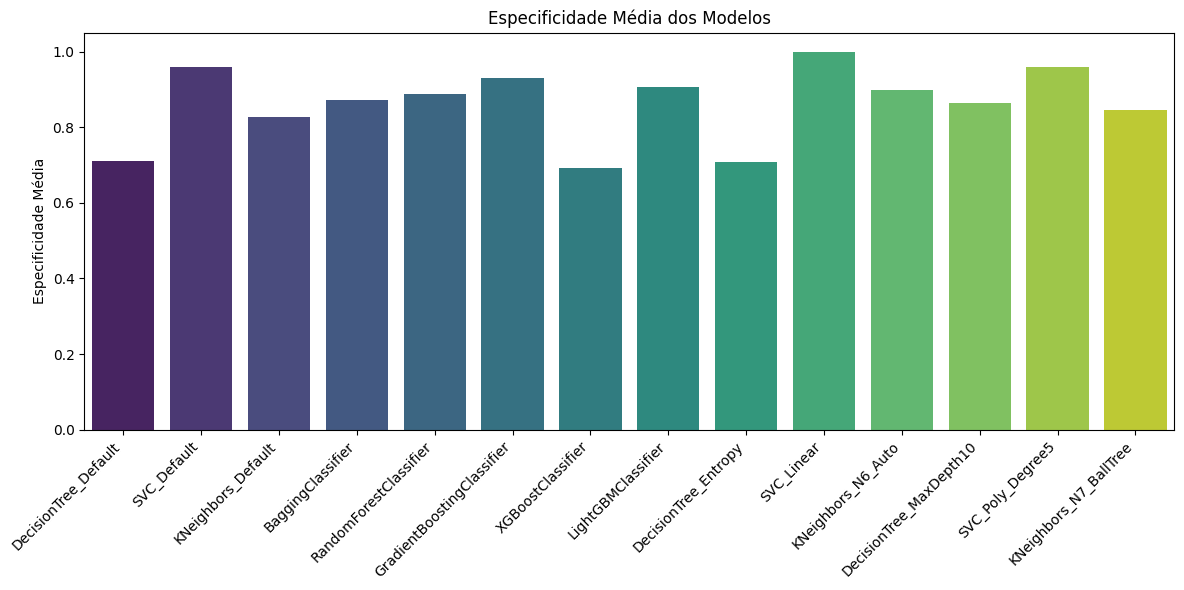

In [23]:
# Specificity
results_df = pd.DataFrame.from_dict(final_results, orient='index')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='avg_specificity', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Especificidade Média')
plt.title('Especificidade Média dos Modelos')
plt.tight_layout()
plt.show()

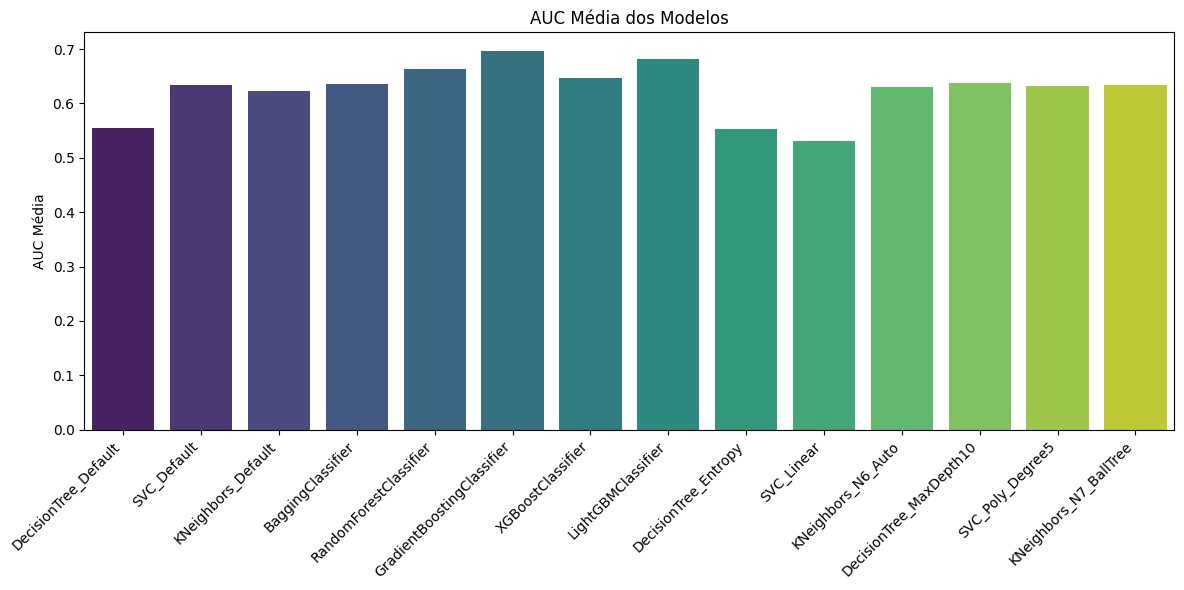

In [24]:
# Área sob a curva
results_df = pd.DataFrame.from_dict(final_results, orient='index')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y='avg_auc', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('AUC Média')
plt.title('AUC Média dos Modelos')
plt.tight_layout()
plt.show()

### Curvas ROC (Receiver Operating Characteristic):

Objetivo: Avaliar a capacidade de um modelo de distinguir entre as classes. A área sob a curva (AUC) é uma métrica importante, e a curva em si mostra o trade-off entre True Positive Rate (Recall) e False Positive Rate.


--- Plotando Curvas ROC Combinadas ---


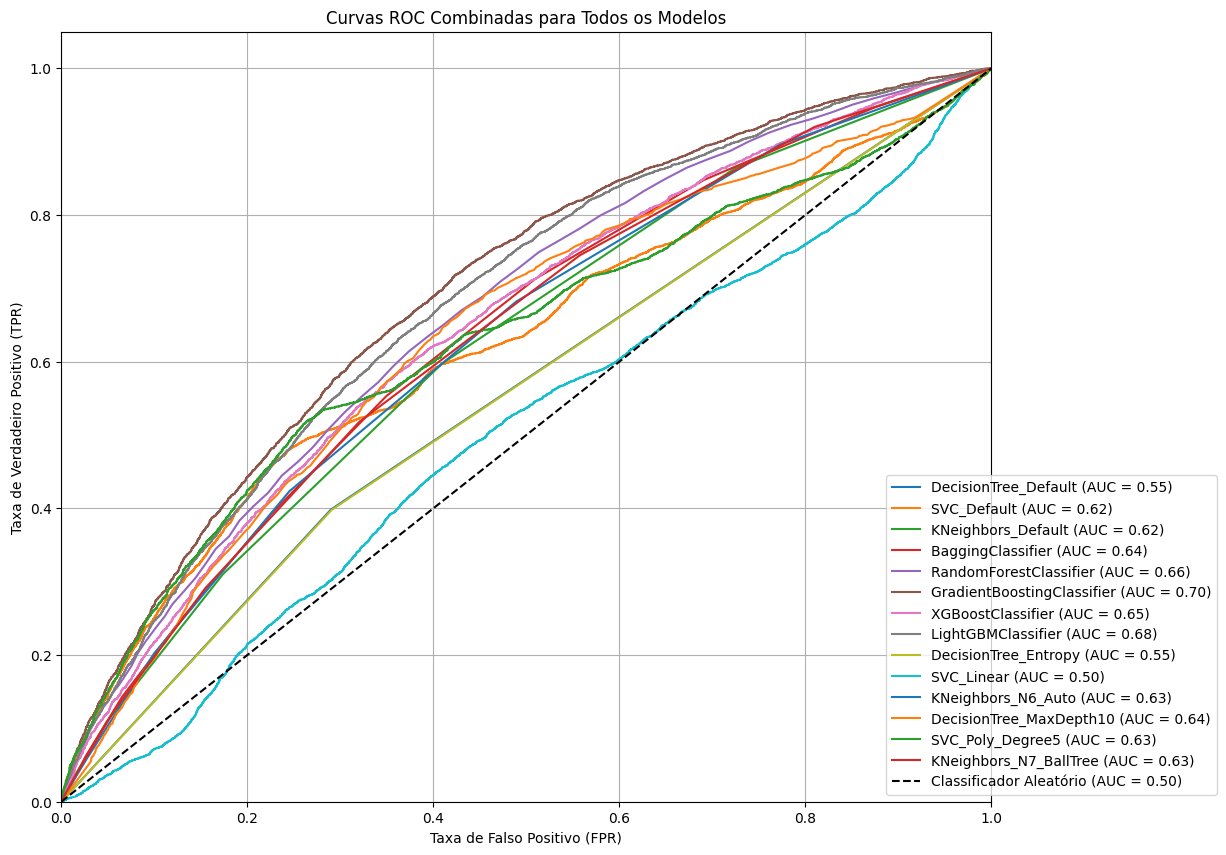

In [25]:
print("\n--- Plotando Curvas ROC Combinadas ---")
plt.figure(figsize=(12, 10)) # Define o tamanho da figura

for model_name, metrics in all_model_metrics.items():
    # Concatena todos os y_true e y_proba de todos os folds para este modelo
    # Filtra arrays vazios que podem ter sido adicionados devido a erros ou modelos sem predict_proba
    y_true_combined = np.concatenate([arr for arr in metrics['y_true_folds'] if arr.size > 0])
    y_proba_combined = np.concatenate([arr for arr in metrics['y_proba_folds'] if arr.size > 0])

    if y_true_combined.size > 0 and y_proba_combined.size > 0:
        try:
            # Calcula a curva ROC
            fpr, tpr, _ = roc_curve(y_true_combined, y_proba_combined)
            roc_auc = auc(fpr, tpr)
            # Plota a curva ROC com o nome do modelo e o valor AUC na legenda
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        except ValueError as e:
            print(f"  Aviso: Não foi possível plotar a curva ROC para {model_name}: {e}")
    else:
        print(f"  Aviso: Dados insuficientes para plotar a curva ROC para {model_name}.")

# Plota a linha diagonal de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.50)')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curvas ROC Combinadas para Todos os Modelos')
# Ajusta a posição da legenda para não sobrepor as curvas
plt.legend(loc="lower right", bbox_to_anchor=(1.25, 0))
plt.grid(True)
plt.show()

Para começar a compreender o AUC, é necessário lembrar que, quanto mais perto de 0,5, mais aleatório. Quanto mais perto de 1, melhor o modelo é em distinguir entre as classes positiva (infectado) e negativa (não infectado).

Portanto, os modelos de melhor desempenho médio foram o GradientBoostingClassifier, LightGBMClassifier, RandomForestClassifier e XGBoostClassifier, nos fazendo perceber que os modelos de boosting foram razoavelmente bem neste dataset.

Os modelos com desempenho médio e baixo (abaixo de 0,65) indicam que talvez não sejam as melhores alternativas para o problema ou que não foram configurados corretamente.

Não realizei tunagem de parâmetros e hiperparâmetros a fundo, então estão muito próximos do padrão.

## --- Conclusão ---

Como dito anteriormente, os modelos de boosting se mostraram os melhores para este dataset, sendo os mais promissores a se trabalhar com. É possível usar o GridSearchCV ou RandomizedSearchCV com parâmetros mais amplos ou refinados para melhorar o desempenho. Porém, devido ao tempo, o aumento pode ou não ser extremamente custoso, acabando por não valer a pena.